In [11]:
#Expand notebook to take full screen width
from IPython.core.display import display, HTML
display(HTML("<style>.container { width:95% !important; }</style>"))

#Jupyter magic to notify when a cell finishes execution with %%notify command -- does not work with Jupyterlab
import jupyternotify
ip = get_ipython()
ip.register_magics(jupyternotify.JupyterNotifyMagics)

<IPython.core.display.Javascript object>

In [1]:
import torch
import torch.nn as nn
import torchvision.transforms as transforms
import torchvision.datasets as dsets
from torch.nn.modules import Module
from torch.autograd import Variable
import torch.nn.functional as F
import numpy as np
import IPython.display as ipd
import imageio
import copy
from tensorboardX import SummaryWriter
import pickle 

writeTensorboard = False
if(writeTensorboard):
    writer = SummaryWriter('tensorboard/run1/')

import seaborn as sns
%matplotlib inline
import matplotlib.pyplot as plt
sns.set(color_codes=True)
sns.set_style("whitegrid")

model_dir = "./models/"
import models
from plot_utils import show_sws_weights, show_weights, print_dims, prune_plot, draw_sws_graphs, joint_plot
from model_utils import test_accuracy, train_epoch, retrain_sws_epoch, model_prune, get_weight_penalty
from helpers import trueAfterN, logsumexp
from sws_utils import GaussianMixturePrior, special_flatten, KL, compute_responsibilies, merger, sws_prune


#Data
train_dataset = dsets.MNIST(root='./data', train=True, transform=transforms.ToTensor(), download=True)
test_dataset = dsets.MNIST(root='./data', train=False , transform=transforms.ToTensor(), download=True)

batch_size = 256
train_loader = torch.utils.data.DataLoader(dataset=train_dataset, batch_size=batch_size, shuffle=True, pin_memory=True)
train_data_full = Variable(train_dataset.train_data.float()/255.0).cuda()
test_data_full = Variable(test_dataset.test_data.float()/255.0).cuda()
train_labels_full = Variable(train_dataset.train_labels).cuda()
test_labels_full = Variable(test_dataset.test_labels).cuda()

#arguments
#model_name = 'LeNet_300_100'
training_epochs=100
#retraining_epochs=50
#temp_list = [1, 5, 10, 15, 20, 25, 30]

In [2]:
#4D tensor fix for conv-net
test_data_full = test_data_full.view(10000, 1, 28, 28)
train_data_full = train_data_full.view(60000, 1, 28, 28)
model_name = 'SWSModel'

### 1. Train Model

**Default Training**

Epoch: 10. Training Accuracy: 99.23. Test Accuracy: 98.65
Epoch: 20. Training Accuracy: 99.54. Test Accuracy: 98.88
Epoch: 30. Training Accuracy: 99.58. Test Accuracy: 98.71
Epoch: 40. Training Accuracy: 99.72. Test Accuracy: 98.98
Epoch: 50. Training Accuracy: 99.76. Test Accuracy: 98.99
Epoch: 60. Training Accuracy: 99.69. Test Accuracy: 98.77
Epoch: 70. Training Accuracy: 99.82. Test Accuracy: 99.04
Epoch: 80. Training Accuracy: 99.79. Test Accuracy: 98.9
Epoch: 90. Training Accuracy: 99.77. Test Accuracy: 99.08
Epoch: 100. Training Accuracy: 99.74. Test Accuracy: 98.91


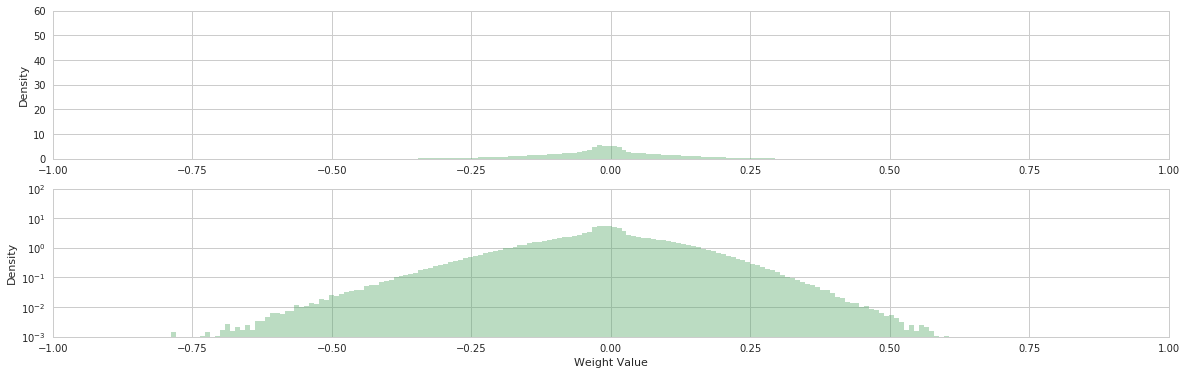

In [6]:
model = models.SWSModel().cuda()
#print_dims(model)
ipd.display(ipd.Markdown("**Default Training**"))

criterion = nn.CrossEntropyLoss()
learning_rate = 1e-3
optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate, weight_decay = 0.000)
graph_title='sws_original_model/'

for epoch in range(training_epochs):
    model, loss = train_epoch(model, optimizer, criterion, train_loader)
    
    test_acc = test_accuracy(test_data_full, test_labels_full, model)
    train_acc = test_accuracy(train_data_full, train_labels_full, model)
    weight_penalty = get_weight_penalty(model)
    
    if(writeTensorboard):
        writer.add_scalars(graph_title + 'CrossEntropyLoss', {'Test': test_acc[1], 'Train': train_acc[1]}, epoch+1)
        writer.add_scalars(graph_title + 'Accuracy', {'Test': test_acc[0], 'Train': train_acc[0]}, epoch+1)
        writer.add_scalars(graph_title + 'L2', {'L2' : weight_penalty}, epoch+1)
        for name, param in model.named_parameters():
            writer.add_histogram(graph_title + name, param.clone().cpu().data.numpy(), epoch+1, bins='doane')
    if (trueAfterN(epoch, 10)):
        print('Epoch: {}. Training Accuracy: {:.2f}. Test Accuracy: {}'.format(epoch+1, train_acc[0], test_acc[0]))
    
show_sws_weights(model)
torch.save(model, model_dir + 'mnist_{}_{}.m'.format(model.name, training_epochs))

### 2. Re-train Model with GMM Constraints

In [12]:
%%notify

alpha, beta = (25000, 10)
model = torch.load(model_dir + 'mnist_{}_{}.m'.format(model_name, training_epochs)).cuda()
model_retrain = torch.load(model_dir + 'mnist_{}_{}.m'.format(model_name, training_epochs)).cuda()
gmp = GaussianMixturePrior(16, [x for x in model_retrain.parameters()], 0.99, ab = (alpha, beta))

test_acc = test_accuracy(test_data_full, test_labels_full, model_retrain)
train_acc = test_accuracy(train_data_full, train_labels_full, model_retrain)
acc_history = np.array([train_acc[0], test_acc[0]])
stddev_history = np.sqrt(1. / gmp.gammas.exp().data.clone().cpu().numpy())
mean_history = gmp.means.data.clone().cpu().numpy()
mixprop_history = gmp.rhos.exp().data.clone().cpu().numpy()

sws_param1 = [gmp.means]
sws_param2 = [gmp.gammas, gmp.rhos]
#ipd.display(ipd.Markdown("**Default Training**"))

criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model_retrain.parameters(), lr=1e-4)
optimizer_gmp1 = torch.optim.Adam(sws_param1, lr=1e-4)
optimizer_gmp2 = torch.optim.Adam(sws_param2, lr=3e-3)
graph_title='retrain_model/'

retraining_epochs = 40
decay = np.linspace(5e-7, 5e-6, retraining_epochs)
#decay = 5e-7 * np.power(10, decay)
#decay = 5e-5 * (1 - 1 / np.power(10, decay))

exp_name = "m{}_a{}_b{}_r{}".format(model_retrain.name, alpha, beta, retraining_epochs)

for epoch in range(retraining_epochs):
    ipd.display(ipd.Markdown("**Epoch: {}**".format(epoch+1)))
    #tau = float(decay[epoch])
    tau=5e-7
    model_retrain, loss = retrain_sws_epoch(model_retrain, gmp, optimizer, optimizer_gmp1, optimizer_gmp2, criterion, train_loader, tau)

    test_acc = test_accuracy(test_data_full, test_labels_full, model_retrain)
    train_acc = test_accuracy(train_data_full, train_labels_full, model_retrain)
    weight_penalty = get_weight_penalty(model_retrain)

    stddev_history = np.vstack((stddev_history,  np.sqrt(1. / gmp.gammas.exp().data.clone().cpu().numpy()) ))
    mean_history = np.vstack((mean_history, gmp.means.data.clone().cpu().numpy() ))
    mixprop_history = np.vstack((mixprop_history, gmp.rhos.exp().data.clone().cpu().numpy() ))
    acc_history = np.vstack(( acc_history, np.array([train_acc[0], test_acc[0]]) ))

    if(writeTensorboard):
        writer.add_scalars(graph_title + 'CrossEntropyLoss', {'Test': test_acc[1], 'Train': train_acc[1]}, epoch+1)
        writer.add_scalars(graph_title + 'Accuracy', {'Test': test_acc[0], 'Train': train_acc[0]}, epoch+1)
        writer.add_scalars(graph_title + 'L2', {'L2' : weight_penalty}, epoch+1)
        for name, param in model_retrain.named_parameters():
            writer.add_histogram(graph_title + name, param.clone().cpu().data.numpy(), epoch+1, bins='doane')
    if (trueAfterN(epoch, 10)):
        gmp.print_batch = True
        print ('Tau:{}'.format(tau))
        print('Epoch: {}. Training Accuracy: {:.2f}. Test Accuracy: {}'.format(epoch+1, train_acc[0], test_acc[0]))
        print ( "Means: {}".format(list(np.around(gmp.means.data.clone().cpu().numpy(),3))) )
        print ( "Mixing Proportions: {}".format(list(np.around(gmp.rhos.data.clone().cpu().numpy(),3))) )
        print ( "Precisions: {}".format(list(np.around(gmp.gammas.data.clone().cpu().numpy(),3))) )
    show_sws_weights(model = model_retrain, means = list(gmp.means.data.clone().cpu()), precisions = list(gmp.gammas.data.clone().cpu()), epoch = epoch, accuracy = test_acc[0], savefile = exp_name)
    joint_plot(model_retrain, model, gmp, epoch, retraining_epochs, test_acc[0], savefile = exp_name)
        #show_all_weights(model_retrain)

0-component Mean: 2500.0 Variance: 1250.0
Non-zero component Mean: 2500.0 Variance: 250.0


**Epoch: 1**

Layer Loss: 625.112
Layer Loss: 15.462
Layer Loss: 8441.525
Layer Loss: 25.001
Layer Loss: 365487.906
Layer Loss: 248.797
Layer Loss: 3303.051
Layer Loss: 5.472
0-neglogprop Loss: -13828.171
Remaining-neglogprop Loss: -1037279.125


**Epoch: 2**

**Epoch: 3**

**Epoch: 4**

**Epoch: 5**

**Epoch: 6**

**Epoch: 7**

**Epoch: 8**

**Epoch: 9**

**Epoch: 10**

Tau:5e-07
Epoch: 10. Training Accuracy: 99.87. Test Accuracy: 98.99
Means: [-0.455, -0.703, -0.393, -0.213, -0.256, -0.132, -0.036, -0.009, 0.034, 0.135, 0.24, 0.348, 0.564, 0.515, 0.333]
Mixing Proportions: [0.057, -2.402, -6.821, -1.508, -0.966, -5.749, -5.35, -5.306, -5.485, -6.134, -6.636, -6.835, -6.748, -3.733, -0.387]
Precisions: [6.479, 7.777, 7.781, 7.794, 7.795, 7.789, 7.794, 7.794, 7.794, 7.794, 7.794, 7.794, 7.794, 7.794, 7.793, 7.756]


**Epoch: 11**

Layer Loss: 4417.844
Layer Loss: 100.653
Layer Loss: 31472.979
Layer Loss: -4.922
Layer Loss: -602094.812
Layer Loss: -607.489
Layer Loss: 9229.902
Layer Loss: 6.055
0-neglogprop Loss: -31085.801
Remaining-neglogprop Loss: -2558656.000


**Epoch: 12**

**Epoch: 13**

**Epoch: 14**

**Epoch: 15**

**Epoch: 16**

**Epoch: 17**

**Epoch: 18**

**Epoch: 19**

**Epoch: 20**

Tau:5e-07
Epoch: 20. Training Accuracy: 99.39. Test Accuracy: 98.55
Means: [-0.453, -0.714, -0.371, -0.177, -0.276, -0.064, -0.065, -0.064, 0.034, 0.231, 0.13, 0.435, 0.601, 0.525, 0.32]
Mixing Proportions: [-2.419, -5.547, -11.627, -1.628, -3.213, -10.167, -4.003, -8.18, -10.285, -10.688, -0.968, -7.073, -11.399, -6.362, -2.805]
Precisions: [11.967, 7.842, 7.821, 7.824, 7.836, 7.829, 7.824, 7.826, 7.824, 7.824, 7.824, 7.706, 7.824, 7.824, 7.824, 7.815]


**Epoch: 21**

Layer Loss: 5760.144
Layer Loss: 173.903
Layer Loss: 4176.729
Layer Loss: -54.853
Layer Loss: -2465841.500
Layer Loss: -2064.976
Layer Loss: 8501.838
Layer Loss: -24.784
0-neglogprop Loss: 255118.562
Remaining-neglogprop Loss: -2558724.000


**Epoch: 22**

**Epoch: 23**

**Epoch: 24**

**Epoch: 25**

**Epoch: 26**

**Epoch: 27**

**Epoch: 28**

**Epoch: 29**

**Epoch: 30**

Tau:5e-07
Epoch: 30. Training Accuracy: 99.53. Test Accuracy: 98.61
Means: [-0.454, -0.716, -0.371, -0.179, -0.281, -0.064, -0.065, -0.064, 0.028, 0.231, 0.132, 0.453, 0.611, 0.536, 0.322]
Mixing Proportions: [-2.355, -5.48, -13.025, -1.553, -3.178, -11.692, -4.009, -9.801, -11.694, -12.116, -0.905, -7.151, -12.854, -6.238, -2.74]
Precisions: [11.971, 7.844, 7.823, 7.824, 7.847, 7.829, 7.824, 7.825, 7.824, 7.824, 7.824, 7.759, 7.824, 7.824, 7.824, 7.818]


**Epoch: 31**

Layer Loss: 5526.537
Layer Loss: 145.413
Layer Loss: 3375.285
Layer Loss: -56.263
Layer Loss: -2468848.750
Layer Loss: -2067.446
Layer Loss: 7885.846
Layer Loss: -25.288
0-neglogprop Loss: 256402.297
Remaining-neglogprop Loss: -2558835.750


**Epoch: 32**

**Epoch: 33**

**Epoch: 34**

**Epoch: 35**

**Epoch: 36**

**Epoch: 37**

**Epoch: 38**

**Epoch: 39**

**Epoch: 40**

Tau:5e-07
Epoch: 40. Training Accuracy: 99.59. Test Accuracy: 98.64
Means: [-0.456, -0.72, -0.371, -0.18, -0.286, -0.064, -0.064, -0.064, 0.028, 0.231, 0.134, 0.466, 0.613, 0.546, 0.324]
Mixing Proportions: [-2.305, -5.431, -14.169, -1.499, -3.14, -12.876, -4.004, -11.015, -12.858, -13.277, -0.855, -7.22, -14.079, -6.133, -2.691]
Precisions: [11.97, 7.845, 7.824, 7.824, 7.855, 7.83, 7.824, 7.825, 7.824, 7.824, 7.824, 7.785, 7.824, 7.824, 7.824, 7.82]


<IPython.core.display.Javascript object>

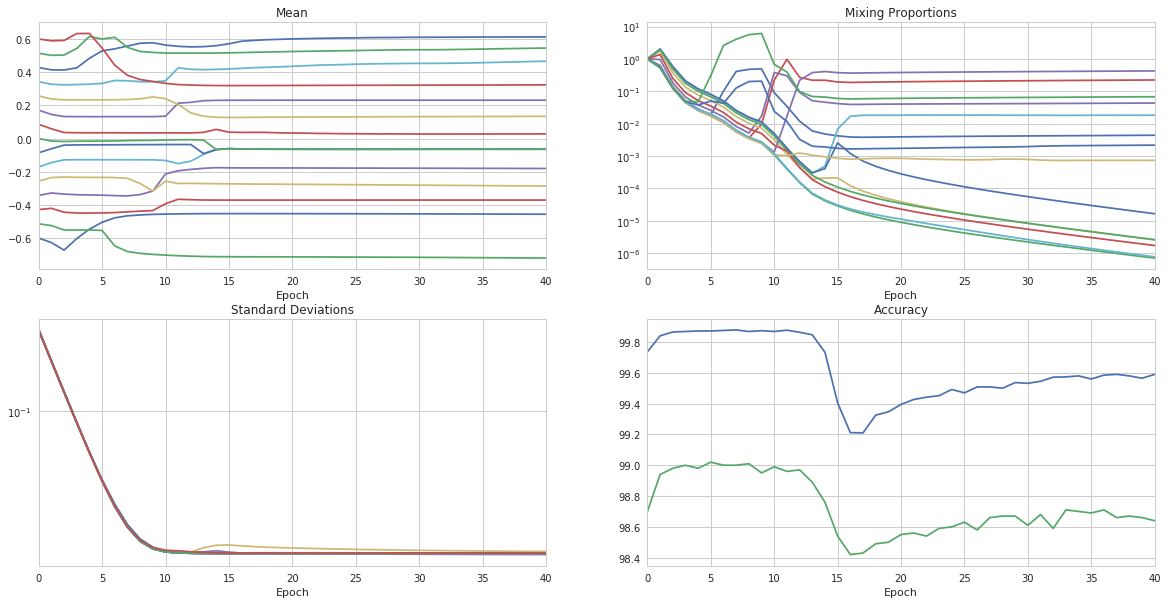

In [13]:
draw_sws_graphs(mean_history, stddev_history, mixprop_history, acc_history, exp_name)
images = []
filenames = ["figs/{}_{}.png".format(exp_name, x) for x in range(1,retraining_epochs+1)]
for filename in filenames:
    images.append(imageio.imread(filename))
imageio.mimsave('./exp/{}.gif'.format(exp_name), images)
torch.save(model_retrain, model_dir + 'mnist_retrain_{}.m'.format(exp_name))
with open(model_dir + 'mnist_retrain_{}.m'.format(exp_name),'wb') as f:
    pickle.dump(gmp, f)
ipd.HTML('<img src="./exp/{}.gif">'.format(exp_name))

In [14]:
images = []
filenames = ["figs/jp_{}_{}.png".format(exp_name, x) for x in range(1,41)]
for filename in filenames:
    images.append(imageio.imread(filename))
imageio.mimsave('./exp/jp_{}.gif'.format(exp_name), images)
ipd.HTML('<img src="./exp/jp_{}.gif">'.format(exp_name))

### 3. Prune Model

(97.17, 1.4925823211669922)


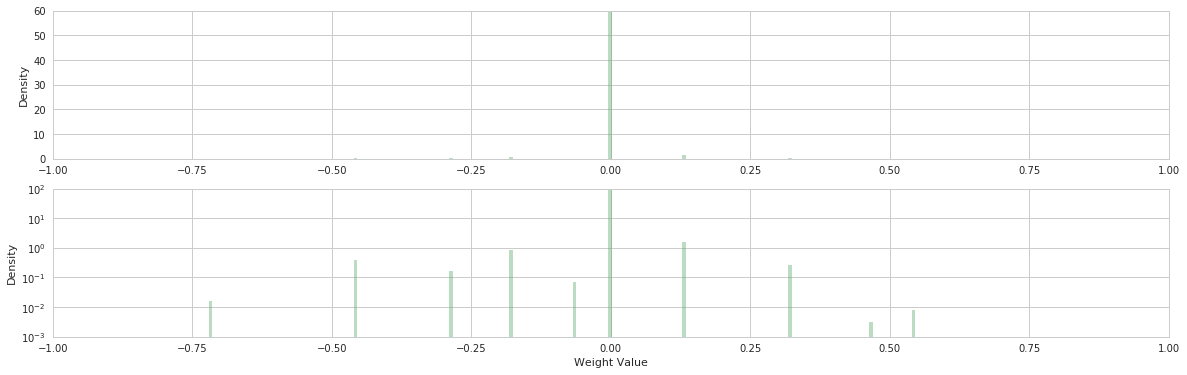

In [20]:
model_prune = copy.deepcopy(model_retrain)
model_prune.load_state_dict(sws_prune(model_prune, gmp))
print (test_accuracy(test_data_full, test_labels_full, model_prune))
show_sws_weights(model_prune)

In [23]:
(special_flatten(model_prune.state_dict())==0).sum()/642460.0

0.9786243501540952